# Make Aerosol Database

POSEIDON currently uses a precomputed aerosol database that stores aerosol Mie scattering properties in it, that retrievals can then pull from. 

This notebook will teach you whats precomputed for the database, how to add your own aerosols into the database, and how to change some assumptions that are currently in the code. 

## Mie Aerosol Types

Aerosols in the database are computed from the refractive indices found in 
- Wakeford & Sing 2014 (https://arxiv.org/abs/1409.7594)
- Kitzmann & Heng 2017 (https://arxiv.org/abs/1710.04946)
- gcmCRT (https://github.com/ELeeAstro/gCMCRT/tree/main/data/nk_tables)
- Burningham 2021 (https://arxiv.org/pdf/2105.04268)
- Misc (see Mullens 2024)

Each aerosol in the database has their effective extinction cross section ($\sigma_{eff,ext}$), effective absorption cross section ($\sigma_{eff,abs}$), effective scattering cross section ($\sigma_{eff,scat}$), effective back scattering cross section ($\sigma_{eff,back}$), effective asymmetry parameter ($g$), and effective single scattering albedo ($\omega$) calculated covering wavelengths from 0.2 to 30 um and particle sizes 0.001 to 10 um (log -3 to 1). 

Particles are assumed to be in a log normal distribution with a width of 0.1 centered around the particle size recorded in the database. 
Aerosols are given a cross section of 0 in regions where refractive index lab data did not span the full 0.2-30 um. 

Cross sections were computed via the python LX-MIE algorithm, and functional forms from PyMieScatt 
- LX-MIE Algorithm (Kitzmann & Heng 2017, https://arxiv.org/abs/1710.04946)
- PLATON Aerosol Implementation (Zhang et al 2018, https://arxiv.org/abs/1811.11761)
- PyMieScatt Mie Efficiences (https://pymiescatt.readthedocs.io/en/latest/forward.html)

For more details, see Mullens 2024.

# Making the Database

POSEIDON v1.2 will come with a precomputed aerosol database with species found in Mullens 2024. 

When adding new species to the database, the database will have to be regenerated. This is how.  

1. Put all relevant jumbo_Mie.npy files in the aerosol_Mie_properties folder in the inputs/opacity folder.
2. Run the following code below

In [ ]:
from POSEIDON.clouds import make_aerosol_database

make_aerosol_database()

## Querying Aerosols in the Database 

Lets check the available species in the database.

In [1]:
from POSEIDON.supported_chemicals import aerosol_supported_species

print(aerosol_supported_species)

['ADP' 'Al2O3' 'Al2O3_KH' 'C' 'CH4' 'CaTiO3' 'CaTiO3_KH' 'Cr'
 'ExoHaze_1000xSolar_300K' 'ExoHaze_1000xSolar_400K' 'Fe' 'Fe2O3'
 'Fe2SiO4_KH' 'FeO' 'FeS' 'FeSiO3' 'H2O' 'H2SO4' 'Hexene' 'Hibonite'
 'IceTholin' 'KCl' 'Mg2SiO4_amorph_sol_gel' 'Mg2SiO4_amorph'
 'Mg2SiO4_Fe_poor' 'Mg2SiO4_Fe_rich' 'Mg2SiO4_crystalline'
 'Mg4Fe6SiO3_amorph_glass' 'Mg5Fe5SiO3_amorph_glass'
 'Mg8Fe12SiO4_amorph_glass' 'Mg8Fe2SiO3_amorph_glass' 'MgAl2O4'
 'MgFeSiO4_amorph_glass' 'MgO' 'MgSiO3_amorph' 'MgSiO3_crystalline'
 'MgSiO3' 'MgSiO3_amorph_glass' 'MgSiO3_sol_gel' 'MnS' 'MnS_KH' 'MnS_Mor'
 'Na2S' 'NaCl' 'NanoDiamonds' 'NH3' 'NH4SH' 'S8' 'Saturn-Phosphorus-Haze'
 'SiC' 'SiO' 'SiO2' 'SiO2_amorph' 'SiO2_crystalline_2023' 'Soot'
 'Soot_6mm' 'Tholin' 'Tholin-CO-0625' 'Tholin-CO-1' 'TiC' 'TiO2_anatase'
 'TiO2_rutile' 'VO' 'ZnS']


Lets query the database directly.

In [3]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'SiO2'

# Intialize wavelength grid
wl_min = 0.2    # Minimum wavelength (um)
wl_max = 30      # Maximum wavelength (um)
R = 10000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 0.01

# This formula loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_abs = sigma_Mie_interp_array[species]['eff_abs']
eff_scat = sigma_Mie_interp_array[species]['eff_scat']
eff_back = sigma_Mie_interp_array[species]['eff_back']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


We will plot the effective extinction cross section, single scattering albedo, and asymmetry parameter. 

Currently, these are the only parameters that are being used in the forward models and retrievals. 

The effective extinction cross section is the total loss of photons due to scattering and absorption processes.

The single scattering albedo ($\omega$) describes how 'forward-scattering' an aerosol is. 0 = Rayleigh limit (isotropic scattering) vs 1 = Forward Scattering. 

The asymmetry parameter ($g$) describes if an aerosol acts primarily as an absorber or a scatterer (0 = completely absorbs, 1 = completely scatters). This parameter can go negative, which means that its 'adding' photos back into the beam. 

$\omega$ and $g$ are used in emission geometries where multiple and forwarding scattering processes are important to consider. 

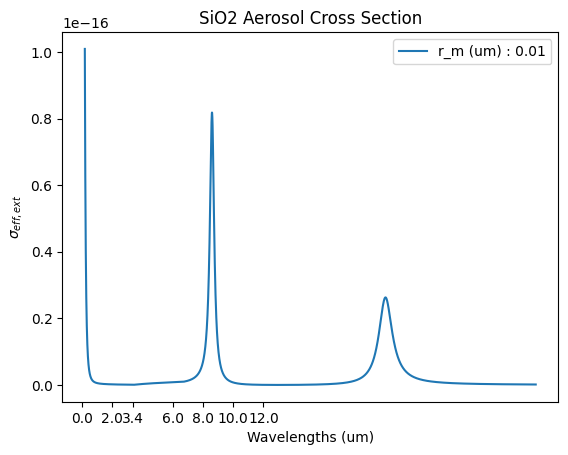

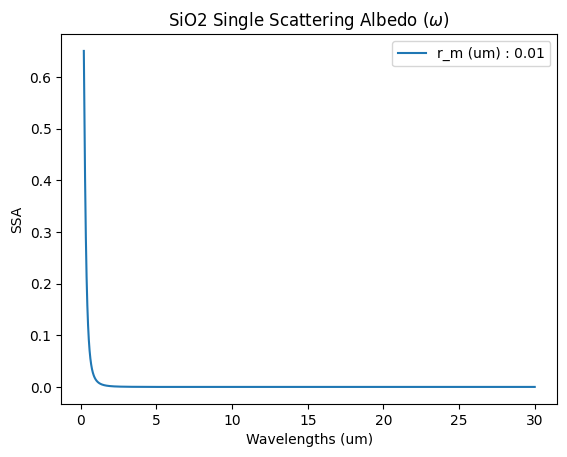

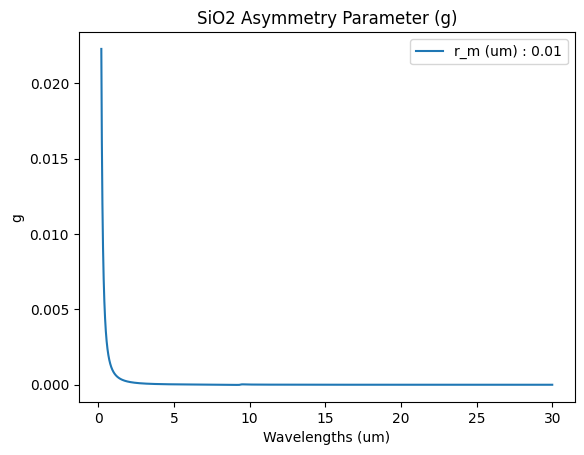

In [4]:
label = 'r_m (um) : ' + str(r_m)
title = species + ' Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.xticks((0,2,3.4,6,8,10,12))
plt.show()

title = species + ' Single Scattering Albedo ($\omega$)'
plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('SSA')
plt.show()


title =species + ' Asymmetry Parameter (g)'
plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('g')
plt.show()

# Directly adding an aerosol to the database

This option is reccomended if retrievals will be run using some lab data. 

To add your own lab data to the database for personal use, run the following code below

I would reccomend writing a .py script and running this command alone in a terminal.

Ensure that the two first lines being a header, or that the headers are commented out with '#'.
The first column being wavelengths (um), second column being the real indices, and the third column being the imaginary indices.

If your lab data is in wavenumber, make sure to convert using wavelength (um) = 1e4/wavenumber (cm-1)

Computing the npy array of cross sections should take about a day. However, good news is that you only have to do it once!

To add your aerosol to the database, place the jumbo_Mie .npy file in the /inputs/opacity/aerosol_Mie_properties folder and rerun make_aerosol_database().

Make sure to update supported_species.py

In [ ]:
from POSEIDON.clouds import precompute_cross_sections_one_aerosol

file_name = './H2O_complex.txt'

# Takes in the file name with the path to it, and the name you want the aerosol to have in the database
precompute_cross_sections_one_aerosol(file_name,'H2O')

# Changing Assumptions

1. Changing the particle size distribution 
2. Changing w and g calculations 

In this section, we will look at how to change some assumptions that are 'baked' into POSEIDON when precomputing aerosol properties. This will require the user to dig into the clouds.py file.

## 1. Changing Particle Size Distribution 

Currrently, POSEIDON assumes a log-normal particle size distribution with a width of 0.5

<img src="./Particle-Size-Distribution.png"/>

However, one might want to explore a different width of the distribution. To do this

1. Access the clouds.py file in POSEIDON directory 
2. Go to the function 'def precompute_cross_sections_one_aerosol(file_name, aerosol_name):


        # Can be changed depending on your preferences
        # (here the main thing to change would be either the lognormal standard devation, r_m_std_dev)
        # (or R_Mie, the resolution at which things are computed)
        r_m_std_dev = 0.5
        z_max = 5
        num_integral_points = 100
        R_Mie = 1000
    
3. Change the constant 'r_m_std_dev = 0.5' to your desired particle size distribution width. 
4. Make sure you name the entry something to indicate the changed size, i.e. 'H2O_width_2'
5. One can also change wich radii are computed. The default is 1e-3 to 10 um, but one can go larger or smaller.

        # Radii are computed from 1e-3 to 10 um. Can also change this if you want
        r_m_array = 10**np.linspace(-3,1,1000)


## 2. Changing w and g calculations 

At the present, POSEIDON computes the effective extinction cross section using an integral over the lognormal distribution, while the asymmetry parameter and single scattering albedo use the median. If one wishes to change this assumption

1. Access the clouds.py file in POSEIDON directory 
2. Go to the function 'def precompute_cross_sections_one_aerosol(file_name, aerosol_name):'
3. Go to the following lines of code : 

        # Effective Cross section is a trapezoidal integral
        eff_ext_cross_section[idx_start:idx_end] = np.trapz(probs*geometric_cross_sections*Qext_intpl, z)

        # Scattering Cross section 
        eff_scat_cross_section[idx_start:idx_end] = np.trapz(probs*geometric_cross_sections*Qscat_intpl, z)

        # Absorption Cross section
        eff_abs_cross_section[idx_start:idx_end] = eff_ext_cross_section[idx_start:idx_end] - eff_scat_cross_section[idx_start:idx_end]

        # BackScatter Cross section 
        eff_back_cross_section[idx_start:idx_end] = np.trapz(probs*geometric_cross_sections*Qback_intpl, z)

        # Effective w and g
        # Can change this to a trapezoidal or a mean if you want
        eff_w[idx_start:idx_end] = np.median(w_intpl, axis=1)
        eff_g[idx_start:idx_end] = np.median(g_intpl, axis=1)

4. Change the eff_w and eff_g to be a np.trapz or a mean